#Import Libraries

##Neptune Ai

In [1]:
! pip install neptune-client==0.4.132


In [2]:
pip install  neptune-contrib neptune-client


In [3]:
import neptune
from neptunecontrib.monitoring.keras import NeptuneMonitor
neptune.init(project_qualified_name='jathurshan0330/DataStorm2-round1', # change this to your `workspace_name/project_name`
             api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiZmJkZjYxNGYtMTA0ZC00ZTc1LWJiMTYtNzczNjgwZWQ3OTUzIn0=', # change this to your api token
            )

Project(jathurshan0330/DataStorm2-round1)

##other necessary libraries

In [4]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy import stats 
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Input,LSTM,Reshape,Conv2D,Flatten,Dropout,BatchNormalization, LeakyReLU, concatenate, GRU, GlobalMaxPooling1D, GlobalMaxPooling2D, Bidirectional

In [5]:
!pip install scikit-plot

#Read Data

##Mount Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
cd '/content/drive/My Drive/Datastorm2.0'

/content/drive/My Drive/Datastorm2.0


In [8]:
!ls '/content/drive/My Drive/Datastorm2.0'

DataStorm2.0_Q1-v2.pdf	     Hotel-A-train.csv	      train_data_upsamp.csv
Hotel-A-data-dictionary.csv  Hotel-A-validation.csv   train_labels_upsamp_2.csv
Hotel-A-test.csv	     train_data_upsamp_2.csv  train_labels_upsamp.csv


##Data

In [9]:
train_data = pd.read_csv('Hotel-A-train.csv')
print(train_data.head()) 
print(train_data.shape)
val_data = pd.read_csv('Hotel-A-validation.csv')
print(val_data.head()) 
print(val_data.shape)
test_data = pd.read_csv('Hotel-A-test.csv')
print(test_data.head())
print(test_data.shape) 



   Reservation-id Gender  Age  ... Use_Promotion Discount_Rate Room_Rate
0        39428300      F   40  ...           Yes            10       218
1        77491756      F   49  ...            No             0       185
2        73747291      F   42  ...            No             0       119
3        67301739      M   25  ...           Yes             5       144
4        77222321      F   62  ...           Yes            10       242

[5 rows x 24 columns]
(27499, 24)
   Reservation-id Gender  Age  ... Use_Promotion Discount_Rate Room_Rate
0        45716350      M   56  ...           Yes            15       192
1        88857401      M   60  ...            No             0       187
2        16074440      F   58  ...           Yes            10       227
3        10992124      F   23  ...           Yes            25       189
4        15934351      F   47  ...           Yes            10       218

[5 rows x 24 columns]
(2749, 24)
   Reservation-id Gender  Age  ... Use_Promotion Discou

In [10]:
print(train_data.isna().sum())
print(val_data.isna().sum())
print(test_data.isna().sum())

Reservation-id            0
Gender                    0
Age                       0
Ethnicity                 0
Educational_Level         0
Income                    0
Country_region            0
Hotel_Type                0
Expected_checkin          0
Expected_checkout         0
Booking_date              0
Adults                    0
Children                  0
Babies                    0
Meal_Type                 0
Visted_Previously         0
Previous_Cancellations    0
Deposit_type              0
Booking_channel           0
Required_Car_Parking      0
Reservation_Status        0
Use_Promotion             0
Discount_Rate             0
Room_Rate                 0
dtype: int64
Reservation-id            0
Gender                    0
Age                       0
Ethnicity                 0
Educational_Level         0
Income                    0
Country_region            0
Hotel_Type                0
Expected_checkin          0
Expected_checkout         0
Booking_date              0
Adults 

In [11]:
train_labels = train_data.pop("Reservation_Status")
print(train_labels.head())

for i in range (len(train_labels)):
  if train_labels[i] == 'Check-In':
    train_labels[i] = 1
  if train_labels[i] == 'Canceled':
    train_labels[i] = 2
  if train_labels[i] == 'No-Show':
    train_labels[i] = 3

print(train_labels.head()) 

val_labels = val_data.pop("Reservation_Status")
print(val_labels.head())

for i in range (len(val_labels)):
  if val_labels[i] == 'Check-In':
    val_labels[i] = 1
   
  if val_labels[i] == 'Canceled':
    val_labels[i] = 2
  if val_labels[i] == 'No-Show':
    val_labels[i] = 3

print(val_labels.head()) 

0    Check-In
1    Check-In
2    Check-In
3    Check-In
4    Check-In
Name: Reservation_Status, dtype: object
0    1
1    1
2    1
3    1
4    1
Name: Reservation_Status, dtype: object
0     No-Show
1    Canceled
2    Canceled
3    Check-In
4    Check-In
Name: Reservation_Status, dtype: object
0    3
1    2
2    2
3    1
4    1
Name: Reservation_Status, dtype: object


In [12]:
print("No of Check-In in training data : " +str((train_labels == 1).sum()))
print("No of Canceled in training data : " +str((train_labels == 2).sum()))
print("No of No-Show in training data : " +str((train_labels == 3).sum()))
tot=(train_labels == 1).sum()+(train_labels == 2).sum()+(train_labels == 3).sum()
print("Ratio of Check-In : Canceled : No-Show  in training data = " +str((train_labels == 1).sum()/tot)+' : '+str((train_labels == 2).sum()/tot)+' : '+str((train_labels == 3).sum()/tot))


print("No of Check-In in validation data : " +str((val_labels == 1).sum()))
print("No of Canceled in validation data : " +str((val_labels == 2).sum()))
print("No of No-Show in validation data : " +str((val_labels == 3).sum()))
tot=(val_labels == 1).sum()+(val_labels == 2).sum()+(val_labels == 3).sum()
print("Ratio of Check-In : Canceled : No-Show  in Validation data = " +str((val_labels == 1).sum()/tot)+' : '+str((val_labels == 2).sum()/tot)+' : '+str((val_labels == 3).sum()/tot))


No of Check-In in training data : 21240
No of Canceled in training data : 4134
No of No-Show in training data : 2125
Ratio of Check-In : Canceled : No-Show  in training data = 0.772391723335394 : 0.15033273937234082 : 0.07727553729226518
No of Check-In in validation data : 1610
No of Canceled in validation data : 741
No of No-Show in validation data : 398
Ratio of Check-In : Canceled : No-Show  in Validation data = 0.5856675154601674 : 0.26955256456893417 : 0.1447799199708985


#Data Preprocessing

##Imbalanced Data Handling

###READ previously saved data

In [13]:
train_data = pd.read_csv('train_data_upsamp.csv')
print(train_data.head()) 
print(train_data.shape)
train_labels = pd.read_csv('train_labels_upsamp.csv')
print(train_labels.head()) 
print(train_labels.shape)
 

   Reservation-id Gender  Age  ... Use_Promotion Discount_Rate Room_Rate
0        39428300      F   40  ...           Yes            10       218
1        77491756      F   49  ...            No             0       185
2        73747291      F   42  ...            No             0       119
3        67301739      M   25  ...           Yes             5       144
4        77222321      F   62  ...           Yes            10       242

[5 rows x 23 columns]
(61035, 23)
   0
0  1
1  1
2  1
3  1
4  1
(61035, 1)


###Upsampling

In [50]:
#Up Sampling   data.iloc [[3, 4], [1, 2]]
temp = train_labels.copy()
for i in range(len(temp)):
  if i%(len(temp)//10)==0:
    print('.',end='')
  if temp[i]==2:
    x = train_data.iloc[i,:]
    x1 = pd.Series(data={'Reservation_Status':2})
  
    train_data = train_data.append(x, ignore_index = True) 
    train_data = train_data.append(x, ignore_index = True) 
    train_data = train_data.append(x, ignore_index = True) 
    train_data = train_data.append(x, ignore_index = True) 
     

    train_labels = train_labels.append(x1, ignore_index = True)
    train_labels = train_labels.append(x1, ignore_index = True)
    train_labels = train_labels.append(x1, ignore_index = True)
    train_labels = train_labels.append(x1, ignore_index = True)
    

  if temp[i]==3:
    x=train_data.iloc[i,:]
    x1 = pd.Series(data={'Reservation_Status':3})
    train_data = train_data.append(x, ignore_index = True) 
    train_data = train_data.append(x, ignore_index = True) 
    train_data = train_data.append(x, ignore_index = True) 
    train_data = train_data.append(x, ignore_index = True) 
    train_data = train_data.append(x, ignore_index = True) 
    train_data = train_data.append(x, ignore_index = True) 
    train_data = train_data.append(x, ignore_index = True) 
    train_data = train_data.append(x, ignore_index = True)
    
    train_labels = train_labels.append(x1, ignore_index = True)
    train_labels = train_labels.append(x1, ignore_index = True)
    train_labels = train_labels.append(x1, ignore_index = True)
    train_labels = train_labels.append(x1, ignore_index = True)
    train_labels = train_labels.append(x1, ignore_index = True)
    train_labels = train_labels.append(x1, ignore_index = True)
    train_labels = train_labels.append(x1, ignore_index = True)
    train_labels = train_labels.append(x1, ignore_index = True)
    #break

print(train_data.shape)
print(x)
print(train_data.iloc[-1,:])
print(train_labels.shape)
print(train_labels.iloc[-1])
print(x1)

...........(61035, 23)
Reservation-id              55243988
Gender                             F
Age                               48
Ethnicity                  caucasian
Educational_Level            College
Income                     25K --50K
Country_region                 North
Hotel_Type                    Resort
Expected_checkin           8/31/2016
Expected_checkout           9/1/2016
Booking_date               6/27/2016
Adults                             3
Children                           1
Babies                             0
Meal_Type                         HB
Visted_Previously                 No
Previous_Cancellations            No
Deposit_type              No Deposit
Booking_channel               Online
Required_Car_Parking              No
Use_Promotion                     No
Discount_Rate                      0
Room_Rate                        210
Name: 27498, dtype: object
Reservation-id              55243988
Gender                             F
Age                      

In [51]:
#Save upsampled data
train_data.to_csv('train_data_upsamp.csv',index=False)
train_labels.to_csv('train_labels_upsamp.csv',index=False)

###Checking Ratios


In [14]:
print("No of Check-In in training data : " +str((train_labels == 1).sum()))
print("No of Canceled in training data : " +str((train_labels == 2).sum()))
print("No of No-Show in training data : " +str((train_labels == 3).sum()))
tot=(train_labels == 1).sum()+(train_labels == 2).sum()+(train_labels == 3).sum()
print("Ratio of Check-In : Canceled : No-Show  in training data = " +str((train_labels == 1).sum()/tot)+' : '+str((train_labels == 2).sum()/tot)+' : '+str((train_labels == 3).sum()/tot))


print("No of Check-In in validation data : " +str((val_labels == 1).sum()))
print("No of Canceled in validation data : " +str((val_labels == 2).sum()))
print("No of No-Show in validation data : " +str((val_labels == 3).sum()))
tot=(val_labels == 1).sum()+(val_labels == 2).sum()+(val_labels == 3).sum()
print("Ratio of Check-In : Canceled : No-Show  in Validation data = " +str((val_labels == 1).sum()/tot)+' : '+str((val_labels == 2).sum()/tot)+' : '+str((val_labels == 3).sum()/tot))


No of Check-In in training data : 0    21240
dtype: int64
No of Canceled in training data : 0    20670
dtype: int64
No of No-Show in training data : 0    19125
dtype: int64
Ratio of Check-In : Canceled : No-Show  in training data = 0    0.347997
dtype: float64 : 0    0.338658
dtype: float64 : 0    0.313345
dtype: float64
No of Check-In in validation data : 1610
No of Canceled in validation data : 741
No of No-Show in validation data : 398
Ratio of Check-In : Canceled : No-Show  in Validation data = 0.5856675154601674 : 0.26955256456893417 : 0.1447799199708985


## Encoding Categorical data

In [15]:
print(train_data.columns)
print(len(train_data.columns))

Index(['Reservation-id', 'Gender', 'Age', 'Ethnicity', 'Educational_Level',
       'Income', 'Country_region', 'Hotel_Type', 'Expected_checkin',
       'Expected_checkout', 'Booking_date', 'Adults', 'Children', 'Babies',
       'Meal_Type', 'Visted_Previously', 'Previous_Cancellations',
       'Deposit_type', 'Booking_channel', 'Required_Car_Parking',
       'Use_Promotion', 'Discount_Rate', 'Room_Rate'],
      dtype='object')
23


In [16]:
#train data
gender_dummies=pd.get_dummies(train_data['Gender'],drop_first=True, prefix='Gen')
gender=train_data.pop('Gender')
train_data=pd.concat([train_data,gender_dummies],axis=1)

eth_dummies=pd.get_dummies(train_data['Ethnicity'],drop_first=False, prefix='Eth')
eth=train_data.pop('Ethnicity')
train_data=pd.concat([train_data,eth_dummies],axis=1)

edu_dummies=pd.get_dummies(train_data['Educational_Level'],drop_first=False, prefix='Edu')
edu=train_data.pop('Educational_Level')
train_data=pd.concat([train_data,edu_dummies],axis=1)

in_dummies=pd.get_dummies(train_data['Income'],drop_first=False, prefix='In')
in_dummies=in_dummies.rename(columns={'In_25K --50K': 'In_25K_50K', 'In_50K -- 100K': 'In_50K_100K', 'In_<25K':'In_below25K', 'In_>100K':'In_above100K' })
income=train_data.pop('Income')
train_data=pd.concat([train_data,in_dummies],axis=1)

region_dummies=pd.get_dummies(train_data['Country_region'],drop_first=False, prefix='Coun')
region=train_data.pop('Country_region')
train_data=pd.concat([train_data,region_dummies],axis=1)

hotel_dummies=pd.get_dummies(train_data['Hotel_Type'],drop_first=False, prefix='Hotel')
hotel=train_data.pop('Hotel_Type')
train_data=pd.concat([train_data,hotel_dummies],axis=1)

meal_dummies=pd.get_dummies(train_data['Meal_Type'],drop_first=False, prefix='Meal')
meal=train_data.pop('Meal_Type')
train_data=pd.concat([train_data,meal_dummies],axis=1)

visit_prev_dummies=pd.get_dummies(train_data['Visted_Previously'],drop_first=True, prefix='Visit')
visit_prev=train_data.pop('Visted_Previously')
train_data=pd.concat([train_data,visit_prev_dummies],axis=1)

prev_can_dummies=pd.get_dummies(train_data['Previous_Cancellations'],drop_first=True, prefix='Prev_can')
prev_can=train_data.pop('Previous_Cancellations')
train_data=pd.concat([train_data,prev_can_dummies],axis=1)

dep_dummies=pd.get_dummies(train_data['Deposit_type'],drop_first=False, prefix='Dep')
dep=train_data.pop('Deposit_type')
train_data=pd.concat([train_data,dep_dummies],axis=1)

book_dummies=pd.get_dummies(train_data['Booking_channel'],drop_first=False, prefix='Book')
book=train_data.pop('Booking_channel')
train_data=pd.concat([train_data,book_dummies],axis=1)

car_dummies=pd.get_dummies(train_data['Required_Car_Parking'],drop_first=True, prefix='Car')
car=train_data.pop('Required_Car_Parking')
train_data=pd.concat([train_data,car_dummies],axis=1)

promo_dummies=pd.get_dummies(train_data['Use_Promotion'],drop_first=True, prefix='Promo')
promo=train_data.pop('Use_Promotion')
train_data=pd.concat([train_data,promo_dummies],axis=1)



print(train_data.columns)
print(train_data.head())

Index(['Reservation-id', 'Age', 'Expected_checkin', 'Expected_checkout',
       'Booking_date', 'Adults', 'Children', 'Babies', 'Discount_Rate',
       'Room_Rate', 'Gen_M', 'Eth_African American', 'Eth_Asian American',
       'Eth_Latino', 'Eth_caucasian', 'Edu_College', 'Edu_Grad',
       'Edu_High-School', 'Edu_Mid-School', 'In_25K_50K', 'In_50K_100K',
       'In_below25K', 'In_above100K', 'Coun_East', 'Coun_North', 'Coun_South',
       'Coun_West', 'Hotel_Airport Hotels', 'Hotel_City Hotel', 'Hotel_Resort',
       'Meal_BB', 'Meal_FB', 'Meal_HB', 'Visit_Yes', 'Prev_can_Yes',
       'Dep_No Deposit', 'Dep_Non-Refundable', 'Dep_Refundable', 'Book_Agent',
       'Book_Direct', 'Book_Online', 'Car_Yes', 'Promo_Yes'],
      dtype='object')
   Reservation-id  Age Expected_checkin  ... Book_Online Car_Yes  Promo_Yes
0        39428300   40         7/1/2015  ...           1       1          1
1        77491756   49         7/1/2015  ...           1       1          0
2        73747291   42 

In [17]:
#Val data
gender_dummies=pd.get_dummies(val_data['Gender'],drop_first=True, prefix='Gen')
gender=val_data.pop('Gender')
val_data=pd.concat([val_data,gender_dummies],axis=1)

eth_dummies=pd.get_dummies(val_data['Ethnicity'],drop_first=False, prefix='Eth')
eth=val_data.pop('Ethnicity')
val_data=pd.concat([val_data,eth_dummies],axis=1)

edu_dummies=pd.get_dummies(val_data['Educational_Level'],drop_first=False, prefix='Edu')
edu=val_data.pop('Educational_Level')
val_data=pd.concat([val_data,edu_dummies],axis=1)

in_dummies=pd.get_dummies(val_data['Income'],drop_first=False, prefix='In')
in_dummies=in_dummies.rename(columns={'In_25K --50K': 'In_25K_50K', 'In_50K -- 100K': 'In_50K_100K', 'In_<25K':'In_below25K', 'In_>100K':'In_above100K' })
income=val_data.pop('Income')
val_data=pd.concat([val_data,in_dummies],axis=1)

region_dummies=pd.get_dummies(val_data['Country_region'],drop_first=False, prefix='Coun')
region=val_data.pop('Country_region')
val_data=pd.concat([val_data,region_dummies],axis=1)

hotel_dummies=pd.get_dummies(val_data['Hotel_Type'],drop_first=False, prefix='Hotel')
hotel=val_data.pop('Hotel_Type')
val_data=pd.concat([val_data,hotel_dummies],axis=1)

meal_dummies=pd.get_dummies(val_data['Meal_Type'],drop_first=False, prefix='Meal')
meal=val_data.pop('Meal_Type')
val_data=pd.concat([val_data,meal_dummies],axis=1)

visit_prev_dummies=pd.get_dummies(val_data['Visted_Previously'],drop_first=True, prefix='Visit')
visit_prev=val_data.pop('Visted_Previously')
val_data=pd.concat([val_data,visit_prev_dummies],axis=1)

prev_can_dummies=pd.get_dummies(val_data['Previous_Cancellations'],drop_first=True, prefix='Prev_can')
prev_can=val_data.pop('Previous_Cancellations')
val_data=pd.concat([val_data,prev_can_dummies],axis=1)

dep_dummies=pd.get_dummies(val_data['Deposit_type'],drop_first=False, prefix='Dep')
dep=val_data.pop('Deposit_type')
val_data=pd.concat([val_data,dep_dummies],axis=1)

book_dummies=pd.get_dummies(val_data['Booking_channel'],drop_first=False, prefix='Book')
book=val_data.pop('Booking_channel')
val_data=pd.concat([val_data,book_dummies],axis=1)

car_dummies=pd.get_dummies(val_data['Required_Car_Parking'],drop_first=True, prefix='Car')
car=val_data.pop('Required_Car_Parking')
val_data=pd.concat([val_data,car_dummies],axis=1)

promo_dummies=pd.get_dummies(val_data['Use_Promotion'],drop_first=True, prefix='Promo')
promo=val_data.pop('Use_Promotion')
val_data=pd.concat([val_data,promo_dummies],axis=1)



print(val_data.columns)
print(val_data.head())

Index(['Reservation-id', 'Age', 'Expected_checkin', 'Expected_checkout',
       'Booking_date', 'Adults', 'Children', 'Babies', 'Discount_Rate',
       'Room_Rate', 'Gen_M', 'Eth_African American', 'Eth_Asian American',
       'Eth_Latino', 'Eth_caucasian', 'Edu_College', 'Edu_Grad',
       'Edu_High-School', 'Edu_Mid-School', 'In_25K_50K', 'In_50K_100K',
       'In_below25K', 'In_above100K', 'Coun_East', 'Coun_North', 'Coun_South',
       'Coun_West', 'Hotel_Airport Hotels', 'Hotel_City Hotel', 'Hotel_Resort',
       'Meal_BB', 'Meal_FB', 'Meal_HB', 'Visit_Yes', 'Prev_can_Yes',
       'Dep_No Deposit', 'Dep_Non-Refundable', 'Dep_Refundable', 'Book_Agent',
       'Book_Direct', 'Book_Online', 'Car_Yes', 'Promo_Yes'],
      dtype='object')
   Reservation-id  Age Expected_checkin  ... Book_Online Car_Yes  Promo_Yes
0        45716350   56        8/31/2016  ...           0       0          1
1        88857401   60        8/31/2016  ...           1       1          0
2        16074440   58 

In [18]:
#test data
gender_dummies=pd.get_dummies(test_data['Gender'],drop_first=True, prefix='Gen')
gender=test_data.pop('Gender')
test_data=pd.concat([test_data,gender_dummies],axis=1)

eth_dummies=pd.get_dummies(test_data['Ethnicity'],drop_first=False, prefix='Eth')
eth=test_data.pop('Ethnicity')
test_data=pd.concat([test_data,eth_dummies],axis=1)

edu_dummies=pd.get_dummies(test_data['Educational_Level'],drop_first=False, prefix='Edu')
edu=test_data.pop('Educational_Level')
test_data=pd.concat([test_data,edu_dummies],axis=1)

in_dummies=pd.get_dummies(test_data['Income'],drop_first=False, prefix='In')
in_dummies=in_dummies.rename(columns={'In_25K --50K': 'In_25K_50K', 'In_50K -- 100K': 'In_50K_100K', 'In_<25K':'In_below25K', 'In_>100K':'In_above100K' })
income=test_data.pop('Income')
test_data=pd.concat([test_data,in_dummies],axis=1)

region_dummies=pd.get_dummies(test_data['Country_region'],drop_first=False, prefix='Coun')
region=test_data.pop('Country_region')
test_data=pd.concat([test_data,region_dummies],axis=1)

hotel_dummies=pd.get_dummies(test_data['Hotel_Type'],drop_first=False, prefix='Hotel')
hotel=test_data.pop('Hotel_Type')
test_data=pd.concat([test_data,hotel_dummies],axis=1)

meal_dummies=pd.get_dummies(test_data['Meal_Type'],drop_first=False, prefix='Meal')
meal=test_data.pop('Meal_Type')
test_data=pd.concat([test_data,meal_dummies],axis=1)

visit_prev_dummies=pd.get_dummies(test_data['Visted_Previously'],drop_first=True, prefix='Visit')
visit_prev=test_data.pop('Visted_Previously')
test_data=pd.concat([test_data,visit_prev_dummies],axis=1)

prev_can_dummies=pd.get_dummies(test_data['Previous_Cancellations'],drop_first=True, prefix='Prev_can')
prev_can=test_data.pop('Previous_Cancellations')
test_data=pd.concat([test_data,prev_can_dummies],axis=1)

dep_dummies=pd.get_dummies(test_data['Deposit_type'],drop_first=False, prefix='Dep')
dep=test_data.pop('Deposit_type')
test_data=pd.concat([test_data,dep_dummies],axis=1)

book_dummies=pd.get_dummies(test_data['Booking_channel'],drop_first=False, prefix='Book')
book=test_data.pop('Booking_channel')
test_data=pd.concat([test_data,book_dummies],axis=1)

car_dummies=pd.get_dummies(test_data['Required_Car_Parking'],drop_first=True, prefix='Car')
car=test_data.pop('Required_Car_Parking')
test_data=pd.concat([test_data,car_dummies],axis=1)

promo_dummies=pd.get_dummies(test_data['Use_Promotion'],drop_first=True, prefix='Promo')
promo=test_data.pop('Use_Promotion')
test_data=pd.concat([test_data,promo_dummies],axis=1)



print(test_data.columns)
print(test_data.head())

Index(['Reservation-id', 'Age', 'Expected_checkin', 'Expected_checkout',
       'Booking_date', 'Adults', 'Children', 'Babies', 'Discount_Rate',
       'Room_Rate', 'Gen_M', 'Eth_African American', 'Eth_Asian American',
       'Eth_Latino', 'Eth_caucasian', 'Edu_College', 'Edu_Grad',
       'Edu_High-School', 'Edu_Mid-School', 'In_25K_50K', 'In_50K_100K',
       'In_below25K', 'In_above100K', 'Coun_East', 'Coun_North', 'Coun_South',
       'Coun_West', 'Hotel_Airport Hotels', 'Hotel_City Hotel', 'Hotel_Resort',
       'Meal_BB', 'Meal_FB', 'Meal_HB', 'Visit_Yes', 'Prev_can_Yes',
       'Dep_No Deposit', 'Dep_Non-Refundable', 'Dep_Refundable', 'Book_Agent',
       'Book_Direct', 'Book_Online', 'Car_Yes', 'Promo_Yes'],
      dtype='object')
   Reservation-id  Age Expected_checkin  ... Book_Online Car_Yes  Promo_Yes
0        62931593   52       11/18/2016  ...           0       1          1
1        70586099   47       11/18/2016  ...           1       0          0
2         4230648   28 

In [19]:
for i in train_data.columns:
  if i not in test_data.columns:
    print(i)

##Label Encoding


In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_labels)
print(le.classes_)
train_label=le.transform(train_labels)

le = preprocessing.LabelEncoder()
le.fit(val_labels)
print(le.classes_)
val_label=le.transform(val_labels)

[1 2 3]
[1 2 3]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##Remove unnecessary columns

In [21]:
train_data.pop('Reservation-id')
val_data.pop('Reservation-id')
test_reservation=test_data['Reservation-id']
test_data.pop('Reservation-id')

train_data.pop('Expected_checkin')
val_data.pop('Expected_checkin')
test_data.pop('Expected_checkin')

train_data.pop('Expected_checkout')
val_data.pop('Expected_checkout')
test_data.pop('Expected_checkout')

train_data.pop('Booking_date')
val_data.pop('Booking_date')
test_data.pop('Booking_date')

0       10/28/2016
1         8/6/2016
2         4/8/2017
3        5/20/2016
4       10/31/2016
           ...    
4313     9/11/2016
4314     2/10/2017
4315     8/26/2016
4316      3/4/2017
4317     3/29/2017
Name: Booking_date, Length: 4318, dtype: object

In [270]:
train_data.pop('Promo_Yes')
val_data.pop('Promo_Yes')
test_data.pop('Promo_Yes')

train_data.pop('Coun_South')
val_data.pop('Coun_South')
test_data.pop('Coun_South')

train_data.pop('Coun_North')
val_data.pop('Coun_North')
test_data.pop('Coun_North')

train_data.pop('Prev_can_Yes')
val_data.pop('Prev_can_Yes')
test_data.pop('Prev_can_Yes')

train_data.pop('Gen_M')
val_data.pop('Gen_M')
test_data.pop('Gen_M')

train_data.pop('Book_Agent')
val_data.pop('Book_Agent')
test_data.pop('Book_Agent')

train_data.pop('Book_Online')
val_data.pop('Book_Online')
test_data.pop('Book_Online')

train_data.pop('Car_Yes')
val_data.pop('Car_Yes')
test_data.pop('Car_Yes')

train_data.pop('Babies')
val_data.pop('Babies')
test_data.pop('Babies')

0       0
1       0
2       0
3       2
4       0
       ..
4313    1
4314    0
4315    0
4316    1
4317    0
Name: Babies, Length: 4318, dtype: int64

#Neptune Create Experiment

In [22]:
neptune.create_experiment(name = 'First Experiment without dates data and testing on multiple models - imbalanced data - up samplin: repeated experiment 3')

NVMLError: Driver Not Loaded - GPU usage metrics may not be reported.


https://ui.neptune.ai/jathurshan0330/DataStorm2-round1/e/DAT-5


Experiment(DAT-5)

#Model Building

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, classification_report, plot_confusion_matrix, precision_score, recall_score
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier

##logistic regression approach

In [27]:
model= LogisticRegression(multi_class='multinomial', solver='saga',max_iter=100) 
model.fit(train_data,train_label) 
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


#neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
#neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
#neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
#neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
#neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train accuracy : 0.42239698533628245
Validation accuracy : 0.3637686431429611
Precision : 0.34506493234186547
Recall : 0.3410410518433471
F1-Score : 0.32389683097603783
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.37      0.46      1610
           1       0.28      0.42      0.34       741
           2       0.14      0.23      0.17       398

    accuracy                           0.36      2749
   macro avg       0.35      0.34      0.32      2749
weighted avg       0.46      0.36      0.39      2749

Confusion Matrix
[[595 637 378]
 [239 313 189]
 [129 177  92]]


NeptuneNoExperimentContextException: ignored

##Decision Tree Classifier model approach

In [25]:
model = DecisionTreeClassifier(max_depth=6, class_weight = 'balanced' ).fit(train_data,train_label)
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

Train accuracy : 0.44947980666830506
Validation accuracy : 0.3481265914878138
Precision : 0.3544390862203218
Recall : 0.34997963359910395
F1-Score : 0.3232809372172543
Classification Report
              precision    recall  f1-score   support

           0       0.63      0.33      0.43      1610
           1       0.29      0.40      0.34       741
           2       0.14      0.32      0.20       398

    accuracy                           0.35      2749
   macro avg       0.35      0.35      0.32      2749
weighted avg       0.47      0.35      0.37      2749

Confusion Matrix
[[536 548 526]
 [203 293 245]
 [117 153 128]]


Feature Importance
[0.05865143 0.04440717 0.00497012 0.         0.02913891 0.10018184
 0.         0.00986069 0.01552003 0.00773025 0.01515455 0.
 0.00792749 0.         0.         0.00959574 0.0098942  0.01503647
 0.01142425 0.01260973 0.         0.         0.00797237 0.03410114
 0.         0.01852521 0.45043774 0.07575361 0.         0.01759748
 0.         0.         0.00736867 0.01600308 0.         0.01413789
 0.         0.         0.00599992]


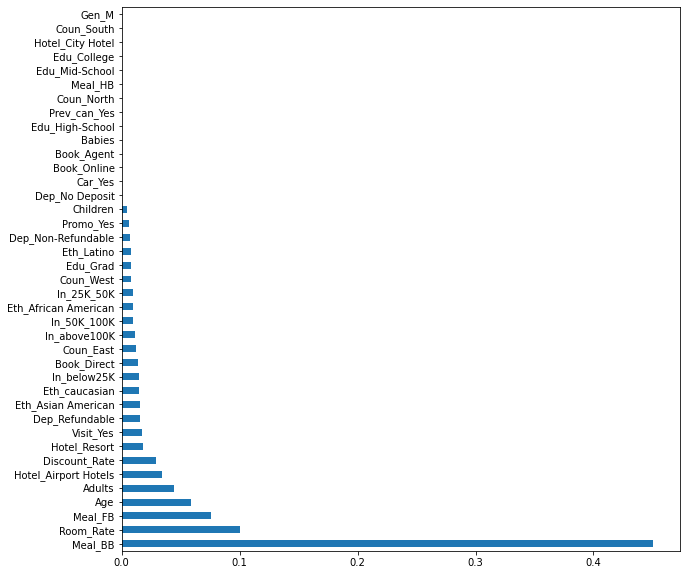

In [76]:
#Feature Importance in Decision Tree Classifier
print("Feature Importance")
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
plt.figure(figsize=[10,10])
feat_importances = pd.Series(model.feature_importances_, index=train_data.columns)
feat_importances.nlargest(40).plot(kind='barh')

plt.show()

##XGB Boost Approach

In [26]:
clf = DecisionTreeClassifier(max_depth=50, class_weight = 'balanced')
model=xgboost.XGBClassifier(base_estimator=clf,max_depth=5,n_estimators=15,objective='multi:softmax',gamma=4.63,learning_rate=0.2,reg_lambda=1).fit(train_data,train_label)
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

Train accuracy : 0.49827148357499795
Validation accuracy : 0.37395416515096397
Precision : 0.34461555646846825
Recall : 0.34232685403643165
F1-Score : 0.3282605929740677
Classification Report
              precision    recall  f1-score   support

           0       0.61      0.39      0.48      1610
           1       0.28      0.42      0.34       741
           2       0.14      0.22      0.17       398

    accuracy                           0.37      2749
   macro avg       0.34      0.34      0.33      2749
weighted avg       0.46      0.37      0.40      2749

Confusion Matrix
[[632 617 361]
 [254 310 177]
 [146 166  86]]


##Support Vector Machine Approach

In [ ]:

model = svm.SVC(degree=9,decision_function_shape='ovo', class_weight = 'balanced')
model.fit(train_data,train_label)       
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

##MLP classifier approach

In [27]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='adam',learning_rate = 'adaptive',learning_rate_init=0.01,activation= 'relu', alpha=1e-6, hidden_layer_sizes=(150, ), random_state=91,max_iter=400)
model.fit(train_data,train_label) 
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

Train accuracy : 0.4153846153846154
Validation accuracy : 0.39578028373954166
Precision : 0.30060198356250983
Recall : 0.35030245625211304
F1-Score : 0.28454348670273094
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.36      0.45      1610
           1       0.28      0.70      0.40       741
           2       0.00      0.00      0.00       398

    accuracy                           0.40      2749
   macro avg       0.30      0.35      0.28      2749
weighted avg       0.44      0.40      0.37      2749

Confusion Matrix
[[ 573 1037    0]
 [ 226  515    0]
 [ 126  272    0]]


##Random Forest approach

In [28]:
model = RandomForestClassifier(max_depth=7,max_features=10,n_estimators=75, class_weight = 'balanced' )
model.fit(train_data,train_label)       
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


#neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
#neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
#neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
#neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
#neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

Train accuracy : 0.5347095928565577
Validation accuracy : 0.35685703892324483
Precision : 0.3529218044904341
Recall : 0.3510127452769726
F1-Score : 0.327664670064097
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.36      0.46      1610
           1       0.29      0.36      0.32       741
           2       0.15      0.33      0.20       398

    accuracy                           0.36      2749
   macro avg       0.35      0.35      0.33      2749
weighted avg       0.46      0.36      0.38      2749

Confusion Matrix
[[581 517 512]
 [229 269 243]
 [126 141 131]]


NeptuneNoExperimentContextException: ignored

##KNN approach

In [23]:
model=KNeighborsClassifier(n_neighbors=3,algorithm='auto',weights='distance')
model.fit(train_data,train_label)       
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


#neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
#neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
#neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
#neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
#neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

Train accuracy : 1.0
Validation accuracy : 0.4608948708621317
Precision : 0.35677239220016704
Recall : 0.35632514028498524
F1-Score : 0.3565113938974585
Classification Report
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      1610
           1       0.28      0.28      0.28       741
           2       0.18      0.17      0.18       398

    accuracy                           0.46      2749
   macro avg       0.36      0.36      0.36      2749
weighted avg       0.46      0.46      0.46      2749

Confusion Matrix
[[990 415 205]
 [426 208 107]
 [215 114  69]]


##Ensemble - extra tree classifier approach

In [28]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(max_depth=6,n_estimators=100, class_weight = 'balanced')
model.fit(train_data, train_label)
y_predict= model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


#neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
#neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
#neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
#neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
#neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

Train accuracy : 0.48644220529204557
Validation accuracy : 0.3481265914878138
Precision : 0.35179287439174445
Recall : 0.3466662151252149
F1-Score : 0.32163322985707016
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.36      0.45      1610
           1       0.29      0.33      0.31       741
           2       0.14      0.36      0.20       398

    accuracy                           0.35      2749
   macro avg       0.35      0.35      0.32      2749
weighted avg       0.46      0.35      0.38      2749

Confusion Matrix
[[572 453 585]
 [226 243 272]
 [126 130 142]]


##Neptune log order of Models

In [31]:
model_list=['logistic regression','Decision Tree Classifier', 'XGB Boost','MLP classifier', 'Random Forest', 'KNN', 'Ensemble - extra tree classifier'  ]
for i in model_list:
  neptune.log_text('Model order',i)

In [32]:
neptune.stop()

#Prediction For submission

In [24]:
y_predict_2= model.predict(test_data)
y_predict_2


array([0, 2, 0, ..., 0, 1, 0])

In [25]:
y_predict_2=le.inverse_transform(y_predict_2)
y_predict_2

array([1, 3, 1, ..., 1, 2, 1], dtype=object)

In [26]:
y_predict_2=pd.DataFrame(y_predict_2,columns=['Reservation_status'] )
y_predict_2

,Reservation_status
0,1
1,3
2,1
3,2
4,2
...,...
4313,2
4314,1
4315,1
4316,2


In [27]:
test_reservation=pd.DataFrame(test_reservation)
test_reservation

,Reservation-id
0,62931593
1,70586099
2,4230648
3,25192322
4,80931528
...,...
4313,39110574
4314,5496554
4315,59004046
4316,65838682


In [28]:
test_reservation=pd.concat([test_reservation,y_predict_2],axis=1)
test_reservation

,Reservation-id,Reservation_status
0,62931593,1
1,70586099,3
2,4230648,1
3,25192322,2
4,80931528,2
...,...,...
4313,39110574,2
4314,5496554,1
4315,59004046,1
4316,65838682,2


In [29]:
test_reservation.to_csv('submission_KNN_upsampled_0.33_0.33_0.33.csv',index=False)